In [2]:
import tweetdf
import geopandas
import pandas
import trips
import odm
import sampers

In [63]:
tweets = tweetdf.from_csv("./../../dbs/Sweden.csv")
tweets.shape

(1276016, 9)

In [65]:
tweets = tweets.dropna()

In [66]:
displacements = trips.from_dfs(tweets)

In [67]:
latlngodm = odm.from_trips(displacements)

In [68]:
latlngodm

,latitude_o,longitude_o,latitude_d,longitude_d,count
0,-79.898133,-49.192753,59.350000,18.066667,1
1,-54.809017,-68.302105,-54.808049,-68.307551,1
2,-54.808219,-68.318154,-54.809017,-68.302105,1
3,-54.808049,-68.307551,-54.783803,-68.259351,1
4,-54.805765,-68.307080,-54.783803,-68.259351,1
...,...,...,...,...,...
380510,78.219557,15.643348,78.207643,15.589768,1
380511,78.220713,15.646880,78.220713,15.646880,1
380512,78.221149,15.644875,78.221149,15.644875,1
380513,78.635166,21.993908,52.233333,21.019444,1


In [7]:
shp = sampers.read_shp(sampers.shps['national'])

In [36]:
countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
sweden = countries[countries.name == "Sweden"]

In [69]:
geolatlngodm = geopandas.GeoDataFrame(
    latlngodm, 
    crs="EPSG:4326", 
    geometry=geopandas.points_from_xy(latlngodm.longitude_o, latlngodm.latitude_o),
)

In [70]:
print(geolatlngodm.shape)
geolatlngodm = geopandas.clip(geolatlngodm, sweden)
print(geolatlngodm.shape)

(380515, 6)
(276883, 6)


In [71]:
geolatlngodm = geolatlngodm.to_crs(shp.crs)

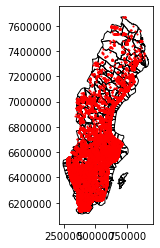

In [72]:
ax = shp.plot(edgecolor='black', facecolor='none', zorder=1)
geolatlngodm.plot(ax=ax, color='red', markersize=1,zorder=2)

In [18]:
geolatlngodm

,latitude_o,longitude_o,latitude_d,longitude_d,count,geometry
0,-37.850497,144.993031,-37.850497,144.993031,1,POINT (4974626.287 -14405902.705)
1,-37.822573,144.969759,-37.818180,144.967874,1,POINT (4979003.438 -14407520.514)
2,-37.765475,144.999465,-37.768194,144.995987,1,POINT (4981056.858 -14415886.858)
3,-34.911528,-57.953708,-34.911027,-57.932324,1,POINT (-6232627.972 -7467635.699)
4,-34.911027,-57.932324,-34.911027,-57.932324,1,POINT (-6231231.268 -7464821.659)
...,...,...,...,...,...,...
50967,68.425577,18.123168,68.348756,18.830859,1,POINT (628115.426 7593561.725)
50968,68.426223,18.124317,68.426223,18.124317,2,POINT (628158.873 7593636.064)
50969,70.981000,25.972757,70.981000,25.972757,1,POINT (897170.055 7911366.505)
50970,70.981000,25.972757,71.171029,25.783281,1,POINT (897170.055 7911366.505)


In [19]:
geopandas.clip(geolatlngodm.head(n=100), shp)

,latitude_o,longitude_o,latitude_d,longitude_d,count,geometry


In [64]:
shp.envelope

0      POLYGON ((658393.039 6594731.437, 670528.578 6...
1      POLYGON ((667794.986 6598266.654, 694251.500 6...
2      POLYGON ((677125.763 6590080.820, 726478.831 6...
3      POLYGON ((690174.216 6579015.376, 694359.782 6...
4      POLYGON ((688873.972 6545495.964, 754312.999 6...
                             ...                        
677    POLYGON ((713293.010 7497654.682, 772552.693 7...
678    POLYGON ((702308.761 7521161.687, 727974.792 7...
679    POLYGON ((624553.955 7528608.267, 736991.764 7...
680    POLYGON ((650033.226 7585065.186, 659413.222 7...
681    POLYGON ((627401.007 7592428.122, 630476.755 7...
Length: 682, dtype: geometry

In [66]:
geopandas.overlay(geolatlngodm, shp, how='intersection')

TypeError: overlay only takes GeoDataFrames with (multi)polygon  geometries.

In [24]:
countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
sweden = countries[countries.name == "Sweden"]

In [27]:
sweden

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
110,9960487,Europe,Sweden,SWE,498100.0,"POLYGON ((11.02737 58.85615, 11.46827 59.43239..."


In [35]:
geopandas.clip(geolatlngodm, sweden)

,latitude_o,longitude_o,latitude_d,longitude_d,count,geometry
3327,55.369262,13.073490,55.338236,13.362678,1,POINT (13.07349 55.36926)
3328,55.373117,13.169574,55.454595,13.188962,1,POINT (13.16957 55.37312)
3329,55.374001,13.126333,55.374165,13.147308,1,POINT (13.12633 55.37400)
3330,55.374001,13.126333,55.375168,13.170333,3,POINT (13.12633 55.37400)
3331,55.374500,13.160500,55.438167,13.312167,1,POINT (13.16050 55.37450)
...,...,...,...,...,...,...
50964,68.406687,18.675265,66.585735,16.270758,1,POINT (18.67526 68.40669)
50965,68.421735,18.107263,68.421735,18.107263,1,POINT (18.10726 68.42173)
50966,68.421735,18.107263,68.428979,18.126876,1,POINT (18.10726 68.42173)
50967,68.425577,18.123168,68.348756,18.830859,1,POINT (18.12317 68.42558)


In [34]:
sweden.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich